# Improving Data Quality

**Learning Objectives**


1. Resolve missing values
2. Convert the Date feature column to a datetime format
3. Rename a feature column, remove a value from a feature column
4. Create one-hot encoding features
5. Understand temporal feature conversions 


## Introduction 

Recall that machine learning models can only consume numeric data, and that numeric data should be "1"s or "0"s.  Data is said to be "messy" or "untidy" if it is missing attribute values, contains noise or outliers, has duplicates, wrong data, upper/lower case column names, and is essentially not ready for ingestion by a machine learning algorithm.  

This notebook presents and solves some of the most common issues of "untidy" data.  Note that different problems will require different methods, and they are beyond the scope of this notebook.

Each learning objective will correspond to a __#TODO__ in the [student lab notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/launching_into_ml/labs/improve_data_quality.ipynb) -- try to complete that notebook first before reviewing this solution notebook.

In [ ]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [ ]:
# Ensure the right version of Tensorflow is installed.
!pip freeze | grep tensorflow==2.1 || pip install tensorflow==2.1

Start by importing the necessary libraries.

### Import Libraries

In [1]:
import os
import pandas as pd  # First, we'll import Pandas, a data processing and CSV file I/O library
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Load the Dataset

The dataset is based on California's [Vehicle Fuel Type Count by Zip Code](https://data.ca.gov/dataset/vehicle-fuel-type-count-by-zip-codeSynthetic) report.  The dataset has been modified to make the data "untidy" and is thus a synthetic representation that can be used for learning purposes.  
  
Let's download the raw .csv data by copying the data from a cloud storage bucket.


In [2]:
if not os.path.isdir("../data/transport"):
    os.makedirs("../data/transport")

In [3]:
!gsutil cp gs://cloud-training-demos/feat_eng/transport/untidy_vehicle_data.csv ../data/transport

Copying gs://cloud-training-demos/feat_eng/transport/untidy_vehicle_data.csv...
/ [1 files][ 47.2 KiB/ 47.2 KiB]                                                
Operation completed over 1 objects/47.2 KiB.                                     


In [4]:
!ls -l ../data/transport

total 48
-rw-r--r-- 1 jupyter jupyter 48343 May 15 04:48 untidy_vehicle_data.csv


### Read Dataset into a Pandas DataFrame

Next, let's read in the dataset just copied from the cloud storage bucket and create a Pandas DataFrame.  We also add a Pandas .head() function to show you the top 5 rows of data in the DataFrame. Head() and Tail() are "best-practice" functions used to investigate datasets.  

In [5]:
df_transport = pd.read_csv('../data/transport/untidy_vehicle_data.csv')
df_transport.head() # Output the first five rows.

,Date,Zip Code,Model Year,Fuel,Make,Light_Duty,Vehicles
0,10/1/2018,90000,2006,Gasoline,OTHER/UNK,NaN,1.0
1,10/1/2018,NaN,2014,Gasoline,NaN,Yes,1.0
2,NaN,90000,NaN,Gasoline,OTHER/UNK,Yes,NaN
3,10/1/2018,90000,2017,Gasoline,OTHER/UNK,Yes,1.0
4,10/1/2018,90000,<2006,Diesel and Diesel Hybrid,OTHER/UNK,No,55.0


### DataFrame Column Data Types

DataFrames may have heterogenous or "mixed" data types, that is, some columns are numbers, some are strings, and some are dates etc. Because CSV files do not contain information on what data types are contained in each column, Pandas infers the data types when loading the data, e.g. if a column contains only numbers, Pandas will set that column’s data type to numeric: integer or float.

Run the next cell to see information on the DataFrame.

In [6]:
df_transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 7 columns):
Date          997 non-null object
Zip Code      997 non-null object
Model Year    997 non-null object
Fuel          996 non-null object
Make          996 non-null object
Light_Duty    996 non-null object
Vehicles      996 non-null float64
dtypes: float64(1), object(6)
memory usage: 54.8+ KB


From what the .info() function shows us, we have six string objects and one float object.  Let's print out the first and last five rows of each column. We can definitely see more of the "string" object values now!

In [7]:
print(df_transport,5)

          Date Zip Code Model Year                      Fuel       Make  \
0    10/1/2018    90000       2006                  Gasoline  OTHER/UNK   
1    10/1/2018      NaN       2014                  Gasoline        NaN   
2          NaN    90000        NaN                  Gasoline  OTHER/UNK   
3    10/1/2018    90000       2017                  Gasoline  OTHER/UNK   
4    10/1/2018    90000      <2006  Diesel and Diesel Hybrid  OTHER/UNK   
..         ...      ...        ...                       ...        ...   
994   6/7/2019    90003       2012                  Gasoline     Type_R   
995   6/8/2019    90003       2012           Hybrid Gasoline  OTHER/UNK   
996   6/9/2019    90003       2012           Hybrid Gasoline     Type_Q   
997  6/10/2019    90003       2012               Natural Gas  OTHER/UNK   
998  6/11/2019    90003       2012            Plug-in Hybrid  OTHER/UNK   

    Light_Duty  Vehicles  
0          NaN       1.0  
1          Yes       1.0  
2          Yes    

### Summary Statistics 

At this point, we have only one column which contains a numerical value (e.g. Vehicles).  For features which contain numerical values, we are often interested in various statistical measures relating to those values.  We can use .describe() to see some summary statistics for the numeric fields in our dataframe. Note, that because we only have one numeric feature, we see only one summary stastic - for now.  

In [8]:
df_transport.describe()

,Vehicles
count,996.000000
mean,72.878514
std,229.696895
min,1.000000
25%,13.000000
50%,23.000000
75%,57.250000
max,3178.000000


Let's investigate a bit more of our data by using the .groupby() function.

In [9]:
grouped_data = df_transport.groupby(['Zip Code','Model Year','Fuel','Make','Light_Duty','Vehicles'])
df_transport.groupby('Fuel').first() # Get the first entry for each month. 

,Date,Zip Code,Model Year,Make,Light_Duty,Vehicles
Fuel,,,,,,
Battery Electric,10/1/2018,90000,<2006,OTHER/UNK,No,4.0
Diesel and Diesel Hybrid,10/1/2018,90000,<2006,OTHER/UNK,No,55.0
Flex-Fuel,10/14/2018,90001,2007,Type_A,Yes,78.0
Gasoline,10/1/2018,90000,2006,OTHER/UNK,Yes,1.0
Hybrid Gasoline,10/24/2018,90001,2009,OTHER/UNK,Yes,18.0
Natural Gas,10/25/2018,90001,2009,OTHER/UNK,No,2.0
Other,10/8/2018,90000,<2006,OTHER/UNK,Yes,6.0
Plug-in Hybrid,11/2/2018,90001,2012,OTHER/UNK,Yes,1.0


#### Checking for Missing Values

Missing values adversely impact data quality, as they can lead the machine learning model to make inaccurate inferences about the data. Missing values can be the result of numerous factors, e.g. "bits" lost during streaming transmission, data entry, or perhaps a user forgot to fill in a field.  Note that Pandas recognizes both empty cells and “NaN” types as missing values. 

Let's show the null values for all features in the DataFrame.

In [10]:
df_transport.isnull().sum()

Date          2
Zip Code      2
Model Year    2
Fuel          3
Make          3
Light_Duty    3
Vehicles      3
dtype: int64

To see a sampling of which values are missing, enter the feature column name.  You'll notice that "False" and "True" correpond to the presence or abscence of a value by index number.

In [11]:
print (df_transport['Date'])
print (df_transport['Date'].isnull())

0      10/1/2018
1      10/1/2018
2            NaN
3      10/1/2018
4      10/1/2018
         ...    
994     6/7/2019
995     6/8/2019
996     6/9/2019
997    6/10/2019
998    6/11/2019
Name: Date, Length: 999, dtype: object
0      False
1      False
2       True
3      False
4      False
       ...  
994    False
995    False
996    False
997    False
998    False
Name: Date, Length: 999, dtype: bool


In [12]:
print (df_transport['Make'])
print (df_transport['Make'].isnull())

0      OTHER/UNK
1            NaN
2      OTHER/UNK
3      OTHER/UNK
4      OTHER/UNK
         ...    
994       Type_R
995    OTHER/UNK
996       Type_Q
997    OTHER/UNK
998    OTHER/UNK
Name: Make, Length: 999, dtype: object
0      False
1       True
2      False
3      False
4      False
       ...  
994    False
995    False
996    False
997    False
998    False
Name: Make, Length: 999, dtype: bool


In [13]:
print (df_transport['Model Year'])
print (df_transport['Model Year'].isnull())

0       2006
1       2014
2        NaN
3       2017
4      <2006
       ...  
994     2012
995     2012
996     2012
997     2012
998     2012
Name: Model Year, Length: 999, dtype: object
0      False
1      False
2       True
3      False
4      False
       ...  
994    False
995    False
996    False
997    False
998    False
Name: Model Year, Length: 999, dtype: bool


### What can we deduce about the data at this point?

First, let's summarize our data by row, column, features, unique, and missing values,

In [14]:
print ("Rows     : " ,df_transport.shape[0])
print ("Columns  : " ,df_transport.shape[1])
print ("\nFeatures : \n" ,df_transport.columns.tolist())
print ("\nUnique values :  \n",df_transport.nunique())
print ("\nMissing values :  ", df_transport.isnull().sum().values.sum())


Rows     :  999
Columns  :  7

Features : 
 ['Date', 'Zip Code', 'Model Year', 'Fuel', 'Make', 'Light_Duty', 'Vehicles']

Unique values :  
 Date          248
Zip Code        6
Model Year     15
Fuel            8
Make           43
Light_Duty      3
Vehicles      210
dtype: int64

Missing values :   18


Let's see the data again -- this time the last five rows in the dataset.

In [15]:
df_transport.tail()

,Date,Zip Code,Model Year,Fuel,Make,Light_Duty,Vehicles
994,6/7/2019,90003,2012,Gasoline,Type_R,Yes,26.0
995,6/8/2019,90003,2012,Hybrid Gasoline,OTHER/UNK,Yes,4.0
996,6/9/2019,90003,2012,Hybrid Gasoline,Type_Q,Yes,25.0
997,6/10/2019,90003,2012,Natural Gas,OTHER/UNK,Yes,1.0
998,6/11/2019,90003,2012,Plug-in Hybrid,OTHER/UNK,Yes,3.0


### What Are Our Data Quality Issues?

1. **Data Quality Issue #1**:  
> **Missing Values**:
Each feature column has multiple missing values.  In fact, we have a total of 18 missing values.
2. **Data Quality Issue #2**: 
> **Date DataType**:  Date is shown as an "object" datatype and should be a datetime.  In addition, Date is in one column.  Our business requirement is to see the Date parsed out to year, month, and day.  
3. **Data Quality Issue #3**: 
> **Model Year**: We are only interested in years greater than 2006, not "<2006".
4. **Data Quality Issue #4**:  
> **Categorical Columns**:  The feature column "Light_Duty" is categorical and has a "Yes/No" choice.  We cannot feed values like this into a machine learning model.  In addition, we need to "one-hot encode the remaining "string"/"object" columns.
5. **Data Quality Issue #5**:  
> **Temporal Features**:  How do we handle year, month, and day?


#### Data Quality Issue #1:  
##### Resolving Missing Values

Most algorithms do not accept missing values.  Yet, when we see missing values in our dataset, there is always a tendency to just "drop all the rows" with missing values.  Although Pandas will fill in the blank space with “NaN", we should "handle" them in some way.

While all the methods to handle missing values is beyond the scope of this lab, there are a few methods you should consider.  For numeric columns, use the "mean" values to fill in the missing numeric values.  For categorical columns, use the "mode" (or most frequent values) to fill in missing categorical values. 

In this lab, we use the .apply and Lambda functions to fill every column with its own most frequent value.  You'll learn more about Lambda functions later in the lab.

Let's check again for missing values by showing how many rows contain NaN values for each feature column.

In [16]:
# TODO 1a
df_transport.isnull().sum()

Date          2
Zip Code      2
Model Year    2
Fuel          3
Make          3
Light_Duty    3
Vehicles      3
dtype: int64

Run the cell to apply the lambda function.

In [17]:
# TODO 1b
df_transport = df_transport.apply(lambda x:x.fillna(x.value_counts().index[0]))

Let's check again for missing values.

In [18]:
# TODO 1c
df_transport.isnull().sum()

Date          0
Zip Code      0
Model Year    0
Fuel          0
Make          0
Light_Duty    0
Vehicles      0
dtype: int64

#### Data Quality Issue #2:  
##### Convert the Date Feature Column to a Datetime Format

The date column is indeed shown as a string object. We can convert it to the datetime datatype with the to_datetime() function in Pandas.

In [19]:
# TODO 2a
df_transport['Date'] =  pd.to_datetime(df_transport['Date'],
                              format='%m/%d/%Y')

In [20]:
# TODO 2b
df_transport.info() # Date is now converted.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 7 columns):
Date          999 non-null datetime64[ns]
Zip Code      999 non-null object
Model Year    999 non-null object
Fuel          999 non-null object
Make          999 non-null object
Light_Duty    999 non-null object
Vehicles      999 non-null float64
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 54.8+ KB


Let's parse Date into three columns, e.g. year, month, and day.

In [21]:
df_transport['year'] = df_transport['Date'].dt.year
df_transport['month'] = df_transport['Date'].dt.month
df_transport['day'] = df_transport['Date'].dt.day
#df['hour'] = df['date'].dt.hour - you could use this if your date format included hour.
#df['minute'] = df['date'].dt.minute - you could use this if your date format included minute.
df_transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 10 columns):
Date          999 non-null datetime64[ns]
Zip Code      999 non-null object
Model Year    999 non-null object
Fuel          999 non-null object
Make          999 non-null object
Light_Duty    999 non-null object
Vehicles      999 non-null float64
year          999 non-null int64
month         999 non-null int64
day           999 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 78.2+ KB


Next, let's confirm the Date parsing.  This will also give us a another visualization of the data.

In [22]:
grouped_data = df_transport.groupby(['Make'])
df_transport.groupby('Fuel').first() # Get the first entry for each month.

,Date,Zip Code,Model Year,Make,Light_Duty,Vehicles,year,month,day
Fuel,,,,,,,,,
Battery Electric,2018-10-01,90000,<2006,OTHER/UNK,No,4.0,2018,10,1
Diesel and Diesel Hybrid,2018-10-01,90000,<2006,OTHER/UNK,No,55.0,2018,10,1
Flex-Fuel,2018-10-14,90001,2007,Type_A,Yes,78.0,2018,10,14
Gasoline,2018-10-01,90000,2006,OTHER/UNK,Yes,1.0,2018,10,1
Hybrid Gasoline,2018-10-24,90001,2009,OTHER/UNK,Yes,18.0,2018,10,24
Natural Gas,2018-10-25,90001,2009,OTHER/UNK,No,2.0,2018,10,25
Other,2018-10-08,90000,<2006,OTHER/UNK,Yes,6.0,2018,10,8
Plug-in Hybrid,2018-11-02,90001,2012,OTHER/UNK,Yes,1.0,2018,11,2


Now that we have Dates as a integers, let's do some additional plotting.

<Figure size 720x432 with 0 Axes>

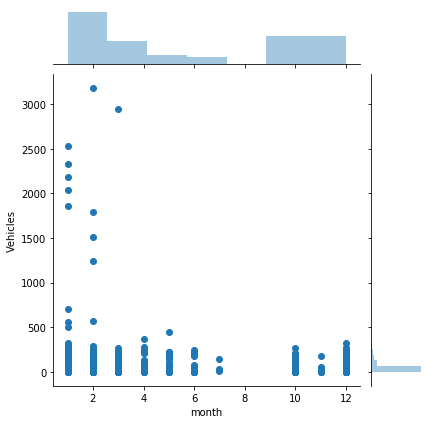

In [23]:
plt.figure(figsize=(10,6))
sns.jointplot(x='month',y='Vehicles',data=df_transport)
#plt.title('Vehicles by Month')

#### Data Quality Issue #3:  
##### Rename a Feature Column and Remove a Value.  

Our feature columns have different "capitalizations" in their names, e.g. both upper and lower "case".  In addition, there are "spaces" in some of the column names.  In addition, we are only interested in years greater than 2006, not "<2006".  

Let's remove all the spaces for feature columns by renaming them; we can also resolve the "case" problem too by making all the feature column names lower case.

In [24]:
# TODO 3a
df_transport.rename(columns = { 'Date': 'date', 'Zip Code':'zipcode', 'Model Year': 'modelyear', 'Fuel': 'fuel', 'Make': 'make', 'Light_Duty': 'lightduty', 'Vehicles': 'vehicles'}, inplace = True) 
df_transport.head(2)

,date,zipcode,modelyear,fuel,make,lightduty,vehicles,year,month,day
0,2018-10-01,90000,2006,Gasoline,OTHER/UNK,Yes,1.0,2018,10,1
1,2018-10-01,90002,2014,Gasoline,OTHER/UNK,Yes,1.0,2018,10,1


 **Note:** Next we create a copy of the dataframe to avoid the "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame" warning.  Run the cell to remove the value '<2006' from the modelyear feature column. 

In [25]:
# Here, we create a copy of the dataframe to avoid copy warning issues.

# TODO 3b

df = df_transport.loc[df_transport.modelyear != '<2006'].copy()

Next, confirm that the modelyear value '<2006' has been removed by doing a value count.

In [26]:
df['modelyear'].value_counts(0)

2007    87
2012    81
2008    79
2011    77
2010    71
2006    70
2015    61
2014    59
2016    57
2017    57
2009    53
2013    52
2018    42
2019     6
Name: modelyear, dtype: int64

#### Data Quality Issue #4:  
##### Handling Categorical Columns

The feature column "lightduty" is categorical and has a "Yes/No" choice.  We cannot feed values like this into a machine learning model.  We need to convert the binary answers from strings of yes/no to integers of 1/0.  There are various methods to achieve this.  We will use the "apply" method with a lambda expression.  Pandas. apply() takes a function and applies it to all values of a Pandas series.

##### What is a Lambda Function?

Typically, Python requires that you define a function using the def keyword. However, lambda functions are anonymous -- which means there is no need to name them. The most common use case for lambda functions is in code that requires a simple one-line function (e.g. lambdas only have a single expression).  

As you progress through the Course Specialization, you will see many examples where lambda functions are being used.  Now is a good time to become familiar with them.

First, lets count the number of "Yes" and"No's" in the 'lightduty' feature column.

In [27]:
df['lightduty'].value_counts(0)

Yes    771
No      80
--       1
Name: lightduty, dtype: int64

Let's convert the Yes to 1 and No to 0. Pandas. apply()  . apply takes a function and applies it to all values of a Pandas series (e.g. lightduty). 

In [28]:
df.loc[:,'lightduty'] = df['lightduty'].apply(lambda x: 0 if x=='No' else 1)
df['lightduty'].value_counts(0)

1    772
0     80
Name: lightduty, dtype: int64

In [29]:
# Confirm that "lightduty" has been converted.

df.head()

,date,zipcode,modelyear,fuel,make,lightduty,vehicles,year,month,day
0,2018-10-01,90000,2006,Gasoline,OTHER/UNK,1,1.0,2018,10,1
1,2018-10-01,90002,2014,Gasoline,OTHER/UNK,1,1.0,2018,10,1
3,2018-10-01,90000,2017,Gasoline,OTHER/UNK,1,1.0,2018,10,1
16,2018-10-09,90001,2006,Diesel and Diesel Hybrid,Type_C,0,16.0,2018,10,9
17,2018-10-10,90001,2006,Diesel and Diesel Hybrid,OTHER/UNK,0,23.0,2018,10,10


#### One-Hot Encoding Categorical Feature Columns

Machine learning algorithms expect input vectors and not categorical features. Specifically, they cannot handle text or string values.  Thus, it is often useful to transform categorical features into vectors.

One transformation method is to create dummy variables for our categorical features.  Dummy variables are a set of binary (0 or 1) variables that each represent a single class from a categorical feature.  We simply  encode the categorical variable as a one-hot vector, i.e. a vector where only one element is non-zero, or hot.  With one-hot encoding, a categorical feature becomes an array whose size is the number of possible choices for that feature.

Panda provides a function called "get_dummies" to convert a categorical variable into dummy/indicator variables.

In [30]:
# Making dummy variables for categorical data with more inputs.  

data_dummy = pd.get_dummies(df[['zipcode','modelyear', 'fuel', 'make']], drop_first=True)
data_dummy.head()

,zipcode_90001,zipcode_90002,zipcode_90003,zipcode_9001,zipcode_na,modelyear_2007,modelyear_2008,modelyear_2009,modelyear_2010,modelyear_2011,...,make_Type_Q,make_Type_R,make_Type_S,make_Type_T,make_Type_U,make_Type_V,make_Type_W,make_Type_X,make_Type_Y,make_Type_Z
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Merging (concatenate) original data frame with 'dummy' dataframe.

# TODO 4a

df = pd.concat([df,data_dummy], axis=1)
df.head()

,date,zipcode,modelyear,fuel,make,lightduty,vehicles,year,month,day,...,make_Type_Q,make_Type_R,make_Type_S,make_Type_T,make_Type_U,make_Type_V,make_Type_W,make_Type_X,make_Type_Y,make_Type_Z
0,2018-10-01,90000,2006,Gasoline,OTHER/UNK,1,1.0,2018,10,1,...,0,0,0,0,0,0,0,0,0,0
1,2018-10-01,90002,2014,Gasoline,OTHER/UNK,1,1.0,2018,10,1,...,0,0,0,0,0,0,0,0,0,0
3,2018-10-01,90000,2017,Gasoline,OTHER/UNK,1,1.0,2018,10,1,...,0,0,0,0,0,0,0,0,0,0
16,2018-10-09,90001,2006,Diesel and Diesel Hybrid,Type_C,0,16.0,2018,10,9,...,0,0,0,0,0,0,0,0,0,0
17,2018-10-10,90001,2006,Diesel and Diesel Hybrid,OTHER/UNK,0,23.0,2018,10,10,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Dropping attributes for which we made dummy variables.  Let's also drop the Date column.

# TODO 4b

df = df.drop(['date','zipcode','modelyear', 'fuel', 'make'], axis=1)


In [33]:
# Confirm that 'zipcode','modelyear', 'fuel', and 'make' have been dropped.

df.head()

,lightduty,vehicles,year,month,day,zipcode_90001,zipcode_90002,zipcode_90003,zipcode_9001,zipcode_na,...,make_Type_Q,make_Type_R,make_Type_S,make_Type_T,make_Type_U,make_Type_V,make_Type_W,make_Type_X,make_Type_Y,make_Type_Z
0,1,1.0,2018,10,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1.0,2018,10,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1.0,2018,10,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,16.0,2018,10,9,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,23.0,2018,10,10,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Data Quality Issue #5:  
##### Temporal Feature Columns

Our dataset now contains year, month, and day feature columns.  Let's convert the month and day feature columns to meaningful representations as a way to get us thinking about changing temporal features -- as they are sometimes overlooked.  

Note that the Feature Engineering course in this Specialization will provide more depth on methods to handle year, month, day, and hour feature columns.

First, let's print the unique values for "month" and "day" in our dataset.

In [34]:
print ('Unique values of month:',df.month.unique())
print ('Unique values of day:',df.day.unique())
print ('Unique values of year:',df.year.unique())

Unique values of month: [10 11 12  1  2  3  4  5  6  7]
Unique values of day: [ 1  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
  2  3  4  5  6  7  8]
Unique values of year: [2018 2019]


Next, we map each temporal variable onto a circle such that the lowest value for that variable appears right next to the largest value. We compute the x- and y- component of that point using sin and cos trigonometric functions.   Don't worry, this is the last time we will use this code, as you can develop an input pipeline to address these temporal feature columns in TensorFlow and Keras - and it is much easier!  But, sometimes you need to appreciate what you're not going to encounter as you move through the course!

Run the cell to view the output.

In [ ]:
df['day_sin'] = np.sin(df.day*(2.*np.pi/31))
df['day_cos'] = np.cos(df.day*(2.*np.pi/31))
df['month_sin'] = np.sin((df.month-1)*(2.*np.pi/12))
df['month_cos'] = np.cos((df.month-1)*(2.*np.pi/12))

# Let's drop month, and day
# TODO 5
df = df.drop(['month','day','year'], axis=1)

In [39]:
# scroll left to see the converted month and day coluumns.
df.tail(4)

,lightduty,vehicles,zipcode_90001,zipcode_90002,zipcode_90003,zipcode_9001,zipcode_na,modelyear_2007,modelyear_2008,modelyear_2009,...,make_Type_U,make_Type_V,make_Type_W,make_Type_X,make_Type_Y,make_Type_Z,day_sin,day_cos,month_sin,month_cos
995,1,4.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.998717,-0.050649,0.5,-0.866025
996,1,25.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.968077,-0.250653,0.5,-0.866025
997,1,1.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.897805,-0.440394,0.5,-0.866025
998,1,3.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.790776,-0.612106,0.5,-0.866025


### Conclusion

This notebook introduced a few concepts to improve data quality.  We resolved missing values, converted the Date feature column to a datetime format, renamed feature columns, removed a value from a feature column, created one-hot encoding features, and converted temporal features to meaningful representations.  By the end of our lab, we gained an understanding as to why data should be "cleaned" and "pre-processed" before input into a machine learning model.

Copyright 2020 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.